In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
import datetime
import time
%matplotlib inline

In [2]:
#Read in data
shots = pd.read_csv('shot_logs.csv', delimiter=',')

print 'dimensions of dataset:', shots.shape
shots.head(3)

dimensions of dataset: (128069, 21)


,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148


In [4]:
data = shots[['GAME_ID', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'SHOT_DIST', 
              'SHOT_RESULT', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS', 'player_id']]

print data.shape

(128069, 12)


In [5]:
data = data[data['SHOT_CLOCK'].notnull()]
#lose 5567 entries

data = data[data['SHOT_CLOCK'] > 1] #results in loss of 1004 shots taken with <1 second on the shot clock

#data = data[data['GAME_CLOCK'] != '0:00'] filtering based on GAME_CLOCK doesn't result in any further loss of entries

#Convert game clock to seconds
T = data['GAME_CLOCK'].values
gameclock_seconds = []

for i in range(T.shape[0]):
    x = T[i].split(':')
    gameclock_seconds.append(60*int(x[0]) + int(x[1]))

data['GAME_CLOCK'] = gameclock_seconds

data = data[data['GAME_CLOCK'] > 1] # results in loss of 2 entries
print data.shape

(121172, 12)


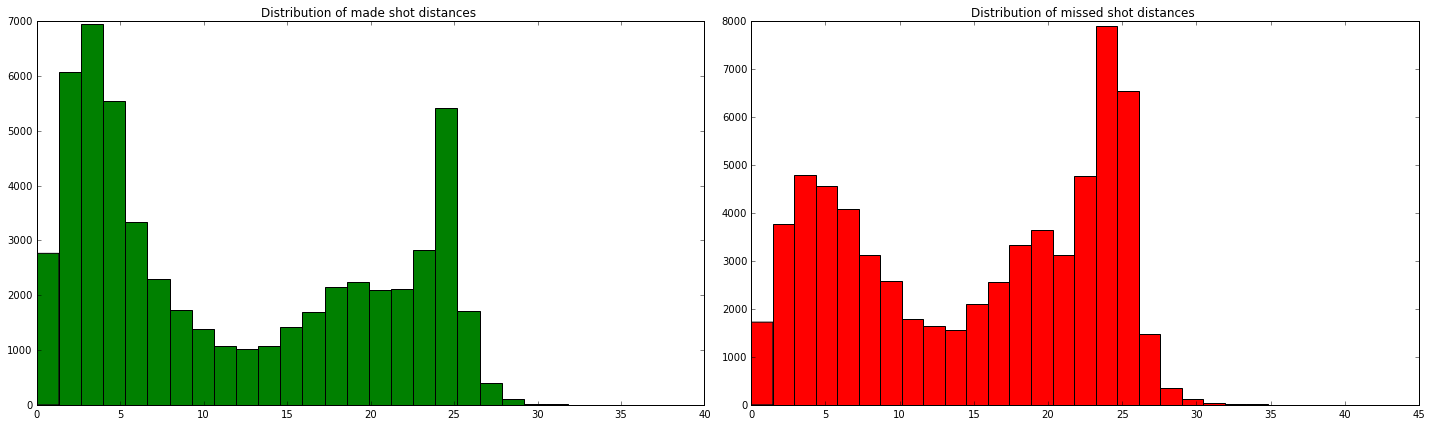

In [6]:
#Plotting shot distances based on whether they were made or missed
subset = data[data['SHOT_RESULT'] == 'made']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

ax1.hist(subset['SHOT_DIST'],30, color='green')
ax1.set_title('Distribution of made shot distances ')

subset = data[data['SHOT_RESULT'] == 'missed']
ax2.hist(subset['SHOT_DIST'],30, color='red')
ax2.set_title('Distribution of missed shot distances ')

plt.tight_layout()    
plt.show()

number of unique player ID: 281
number of unique game ID: 896


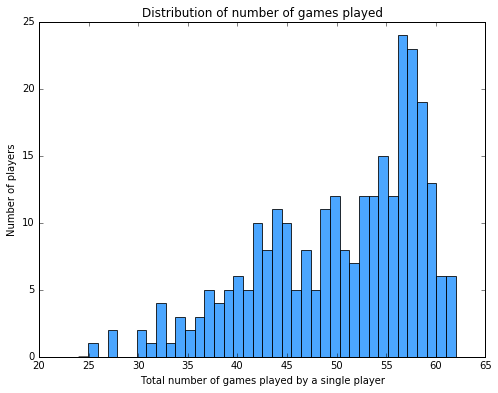

In [7]:
# There are actually data from 281 players
print 'number of unique player ID:', np.unique(data['player_id'].values).shape[0] 
# print 'number of unique player names:', np.unique(data['player_name'].values).shape[0]
player_id = np.unique(data['player_id'].values)
# player_name = np.unique(data['player_name'].values)

# How many unique games are there (should there be 30 * 82 / 2 = 1230 games?)
# Several players may share the same game ID (becuase they all played that night)
print 'number of unique game ID:', np.unique(data['GAME_ID'].values).shape[0]

# Create a dictionary where player_id is the key and all associated unique game IDs are the values
gameID_by_player = {}
for player in player_id:
    gameID_by_player[player] = np.unique(data[data['player_id'] == player]['GAME_ID'])


# games_per_player, in same order as player_id, contains the number of games played by per player
games_per_player = np.array([gameID_by_player[player].shape[0] for player in player_id])
    
# Plot the distribution of number of games played by all players    
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

bin_max = games_per_player.max() + 1
bin_min = games_per_player.min() - 1
bins = bin_max - bin_min + 1

ax.hist(games_per_player, bins = bins, range = (bin_min, bin_max), color='dodgerblue', alpha = 0.8)
ax.set_title('Distribution of number of games played')
ax.set_xlabel('Total number of games played by a single player')
ax.set_ylabel('Number of players')
plt.show()

In [8]:
# shots_by_player is a dictionary where player_id is the key and number of shots made per game are the values
# shots_by_player is in the same order as gameID_by_player
shots_by_player = {}
for player in player_id:
    shots_by_player[player] = np.array([data[(data['player_id'] == player) & (data['GAME_ID'] == game)].shape[0] 
                                        for game in gameID_by_player[player]])

How many unique shot series do we have?  14165


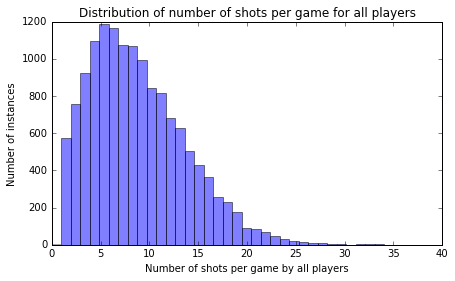

Shoot series with length smaller than 4 comprises: 15.9% of all shot series


In [9]:
# I want to come up with a better way to visualize the data above. (For individual players)
# However, for now:

# Make an array combining number of shots made per game by all the players
shots_by_all_players = np.array([]).astype(int)
for player in player_id:
    shots_by_all_players = np.append(shots_by_all_players, shots_by_player[player])

# Get the number of unique shot series
print 'How many unique shot series do we have? ', shots_by_all_players.shape[0]
# print sum(games_per_player) # Sanity chekc also 14165

fig, ax = plt.subplots(1, 1, figsize = (7,4))

bin_max = shots_by_all_players.max() + 1
bin_min = shots_by_all_players.min() - 1
bins = bin_max - bin_min + 1

ax.hist(shots_by_all_players, bins = bins, range = [bin_min, bin_max], color = 'b', alpha = 0.5)

ax.set_title('Distribution of number of shots per game for all players')
ax.set_xlabel('Number of shots per game by all players')
ax.set_ylabel('Number of instances')
plt.show()

print 'Shoot series with length smaller than 4 comprises: {:.1f}% of all shot series'.format(
    float(shots_by_all_players[shots_by_all_players < 4].shape[0]) / float(shots_by_all_players.shape[0]) * 100)
# We will throw away 15.9% of shot series

In [10]:
# Make a new column that contains the length of the shot series that the shot is associated with
# This will be useful for filtering purposes

## Testing
# print gameID_by_player[708]
# print int(shots_by_player[708][np.where(gameID_by_player[708] == 21400902)])

# Actual execution
data['shot_series_length'] = [int(shots_by_player[data['player_id'].iloc[i]][np.where(gameID_by_player[data['player_id'].iloc[i]] == data['GAME_ID'].iloc[i])]) for i in range(data.shape[0])]

In [11]:
# Sanity check
data.iloc[:50]

,GAME_ID,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length
0,21400899,1,1,69,10.8,7.7,made,101187,1.3,1,2,203148,8
1,21400899,2,1,14,3.4,28.2,missed,202711,6.1,0,0,203148,8
3,21400899,4,2,707,10.3,17.2,missed,203900,3.4,0,0,203148,8
4,21400899,5,2,634,10.9,3.7,missed,201152,1.1,0,0,203148,8
5,21400899,6,2,495,9.1,18.4,missed,101114,2.6,0,0,203148,8
6,21400899,7,4,615,14.5,20.7,missed,101127,6.1,0,0,203148,8
7,21400899,8,4,480,3.4,3.5,made,203486,2.1,1,2,203148,8
8,21400899,9,4,314,12.4,24.6,missed,202721,7.3,0,0,203148,8
9,21400890,1,2,692,17.4,22.4,missed,201961,19.8,0,0,203148,4
10,21400890,2,2,390,16.0,24.5,missed,202391,4.7,0,0,203148,4


number of unique player ID: 281


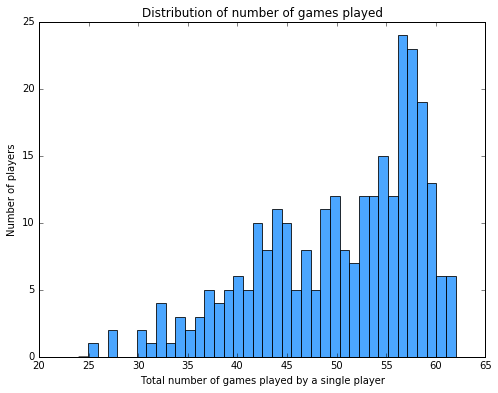

In [12]:

# Did any players drop out after this?

# There are still 280 players. Only one dropped out.
print 'number of unique player ID:', np.unique(data['player_id'].values).shape[0] 

player_id = np.unique(data['player_id'].values)

# Create a dictionary where player_id is the key and all associated unique game IDs are the values
gameID_by_player = {}
for player in player_id:
    gameID_by_player[player] = np.unique(data[data['player_id'] == player]['GAME_ID'])

# games_per_player, in same order as player_id, contains the number of games played by per player
games_per_player = np.array([gameID_by_player[player].shape[0] for player in player_id])
    
# Plot the distribution of number of games played by all players    
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

bin_max = games_per_player.max() + 1
bin_min = games_per_player.min() - 1
bins = bin_max - bin_min + 1

ax.hist(games_per_player, bins = bins, range = (bin_min, bin_max), color='dodgerblue', alpha = 0.8)
ax.set_title('Distribution of number of games played')
ax.set_xlabel('Total number of games played by a single player')
ax.set_ylabel('Number of players')
plt.show()

### Should we consider throwing away players with too few shot series because they do not have representative sample size?
### Let's leave it like this and move on for now

In [13]:
#Create new dataframe so that gameID is ordered numerically
final_df = pd.DataFrame(columns=data.columns)
final_df['MAKE_STREAK'] = []
final_df.head()

#iterate through data grouped by gameid
for _, sub_df in data.groupby('GAME_ID'):
    makestreak = []
    count = 0
    for _, row in sub_df.iterrows():
        if (row['SHOT_RESULT'] == 'made'):
            count += 1
            makestreak.append(count)
        else:
            count = 0
            makestreak.append(count)
    sub_df['MAKE_STREAK'] = makestreak
    final_df = final_df.append(sub_df, ignore_index=True)
    
final_df.head()

C:\Users\Bailey\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,GAME_ID,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length,MAKE_STREAK
0,21400001.0,1.0,1.0,607.0,11.3,3.6,made,202696.0,1.7,1.0,2.0,201600.0,10.0,1.0
1,21400001.0,2.0,1.0,579.0,13.0,0.9,missed,203124.0,2.0,0.0,0.0,201600.0,10.0,0.0
2,21400001.0,3.0,1.0,435.0,11.5,0.8,made,202699.0,2.6,1.0,2.0,201600.0,10.0,1.0
3,21400001.0,4.0,1.0,314.0,21.6,3.4,missed,203095.0,1.5,0.0,0.0,201600.0,10.0,0.0
4,21400001.0,5.0,1.0,112.0,15.9,2.6,made,203473.0,4.5,1.0,2.0,201600.0,10.0,1.0


In [14]:
final_df2 = pd.DataFrame(columns=final_df.columns)
final_df2['MISS_STREAK'] = []
final_df2.head()

for _, sub_df in final_df.groupby('GAME_ID'):
    missstreak = []
    count = 0
    for _, row in sub_df.iterrows():
        if (row['SHOT_RESULT'] == 'missed'):
            count += 1
            missstreak.append(count)
        else:
            count = 0
            missstreak.append(count)
    sub_df['MISS_STREAK'] = missstreak
    final_df2 = final_df2.append(sub_df, ignore_index=True)
    
final_df2.head(20)

C:\Users\Bailey\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,GAME_ID,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,shot_series_length,MAKE_STREAK,MISS_STREAK
0,21400001.0,1.0,1.0,607.0,11.3,3.6,made,202696.0,1.7,1.0,2.0,201600.0,10.0,1.0,0.0
1,21400001.0,2.0,1.0,579.0,13.0,0.9,missed,203124.0,2.0,0.0,0.0,201600.0,10.0,0.0,1.0
2,21400001.0,3.0,1.0,435.0,11.5,0.8,made,202699.0,2.6,1.0,2.0,201600.0,10.0,1.0,0.0
3,21400001.0,4.0,1.0,314.0,21.6,3.4,missed,203095.0,1.5,0.0,0.0,201600.0,10.0,0.0,1.0
4,21400001.0,5.0,1.0,112.0,15.9,2.6,made,203473.0,4.5,1.0,2.0,201600.0,10.0,1.0,0.0
5,21400001.0,6.0,1.0,75.0,24.0,2.7,made,203473.0,1.7,1.0,2.0,201600.0,10.0,2.0,0.0
6,21400001.0,7.0,2.0,647.0,22.6,1.2,made,202696.0,3.6,1.0,2.0,201600.0,10.0,3.0,0.0
7,21400001.0,8.0,2.0,361.0,23.1,2.3,made,203124.0,2.1,1.0,2.0,201600.0,10.0,4.0,0.0
8,21400001.0,9.0,3.0,659.0,8.4,3.6,missed,202696.0,2.2,0.0,0.0,201600.0,10.0,0.0,1.0
9,21400001.0,10.0,4.0,157.0,23.6,0.6,made,203473.0,1.4,1.0,2.0,201600.0,10.0,1.0,0.0
